# CNN classifier

Congratulations, here's your first homework! You'll learn the art of training deep image classifiers. You might remember `03 seminar` about training CIFAR10 classifier, this homework is also about training **CIFAR10 classifier**, but this time you'll have to do it on your own and with some extra features.

## Data
Your dataset is CIFAR10. Check out `03 seminar` on how to load train and val data splits.

**Note:** for training you can only use `train` dataset.

## Game rules:
Maximum score you can get for this task is **10.0**.

Half of 10 points you can get by reaching high val accuracy (as listed in table below):

- accuracy > 60.0 -> **1 point**
- accuracy > 70.0 -> **2 points**
- accuracy > 80.0 -> **3 points**
- accuracy > 90.0 -> **4 points**
- accuracy > 92.5 -> **5 points**

Another half of 10 points you can get by adding following features to your training pipeline. It's okay if you see some technics for the first time (that was the idea). Feel free to google and dive into topic on your own, it's homework after all:
1. Data augmentations. Check out [this article](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced) (**1 point**)
2. [LR schedule](https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.ReduceLROnPlateau) (**0.5 point**)
3. Finetune pretrained model from [torchvision.models](https://pytorch.org/docs/stable/torchvision/models.html) (except AlexNet!) (**1 point**)
4. Implement [ResNet model](https://medium.com/@14prakash/understanding-and-implementing-architectures-of-resnet-and-resnext-for-state-of-the-art-image-cf51669e1624) (**2 points**)
5. Use of [tensorboardX](https://github.com/lanpa/tensorboardX) to monitor training process (**0.5 points**)

As a result you have to submit **notebook with working code** (results will be reproduced during homework cheking) and **short report** (write it in the same notebook) about things you tried and what tasks you managed to implement. Good luck and have fun!

### Report
- accuracy more than 60%
- LR schedule
- tensorboardx

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

batch_size = 4
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [14]:
train_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

val_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)
val_dataloader= torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np


def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    img = img.cpu().numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images.shape = torch.Size([4, 3, 32, 32])
labels = tensor([1, 2, 7, 1])
labels.shape = torch.Size([4])


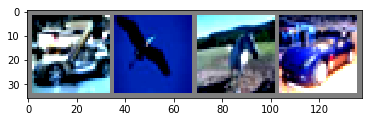

  car  bird horse   car


In [5]:
# get some random training images
images, labels = next(iter(train_dataloader))

print("images.shape =", images.shape)

print("labels =", labels)
print("labels.shape =", labels.shape)

# show images
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [6]:
# import torch.nn as nn
# import torch.nn.functional as F


# class SimpleConvNet(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(3, 6, 5, padding=2)
#         self.conv2 = nn.Conv2d(6, 16, 5, padding=2)
        
#         self.pool = nn.MaxPool2d(2)
        
#         self.l1 = nn.Linear(16 * 8 * 8, 128)
#         self.l2 = nn.Linear(128, 64)
#         self.l3 = nn.Linear(64, 10)
        
#     def forward(self, x):
#         x = F.relu(self.pool(self.conv1(x)))
#         x = F.relu(self.pool(self.conv2(x)))
        
#         x = x.view(-1, 16 * 8 * 8)
        
#         x = F.relu(self.l1(x))
#         x = F.relu(self.l2(x))  
#         x = self.l3(x)
        
#         return x


# model = SimpleConvNet().to(device)

In [27]:
# Simple DenseNet

class Dense_Block(nn.Module):
    def __init__(self, in_channels):
        super(Dense_Block, self).__init__()

        self.relu = nn.ReLU(inplace=True)
        self.bn = nn.BatchNorm2d(num_features=in_channels)

        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=32, 
                               kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, 
                               kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=32, 
                               kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=96, out_channels=32, 
                               kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=32, 
                               kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        bn = self.bn(x)
        conv1 = self.relu(self.conv1(bn))

        conv2 = self.relu(self.conv2(conv1))
        c2_dense = self.relu(torch.cat([conv1, conv2], 1))

        conv3 = self.relu(self.conv3(c2_dense))
        c3_dense = self.relu(torch.cat([conv1, conv2, conv3], 1))

        conv4 = self.relu(self.conv4(c3_dense))
        c4_dense = self.relu(torch.cat([conv1, conv2, conv3, conv4], 1))

        conv5 = self.relu(self.conv5(c4_dense))
        c5_dense = self.relu(torch.cat([conv1, conv2, conv3, conv4, conv5], 1))

        return c5_dense

class Transition_Layer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Transition_Layer, self).__init__()

        self.relu = nn.ReLU(inplace=True)
        self.bn = nn.BatchNorm2d(num_features=out_channels)
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                              kernel_size=1, bias=False)
        self.avg_pool = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)

    def forward(self, x):

        bn = self.bn(self.relu(self.conv(x)))
        out = self.avg_pool(bn)

        return out

class DenseNet(nn.Module):
    def __init__(self, nr_classes):
        super(DenseNet, self).__init__()

        self.lowconv = nn.Conv2d(in_channels=3, out_channels=64, 
                                 kernel_size=7, padding=3, bias=False)
        self.relu = nn.ReLU()

        # Make Dense Blocks
        self.denseblock1 = self._make_dense_block(Dense_Block, 64)
        self.denseblock2 = self._make_dense_block(Dense_Block, 128)
        self.denseblock3 = self._make_dense_block(Dense_Block, 128)

        # Make transition Layers
        self.transitionLayer1 = self._make_transition_layer(
            Transition_Layer, in_channels=160, out_channels=128)
        self.transitionLayer2 = self._make_transition_layer(
            Transition_Layer, in_channels=160, out_channels=128)
        self.transitionLayer3 = self._make_transition_layer(
            Transition_Layer, in_channels=160, out_channels=64)

        # Classifier
        self.bn = nn.BatchNorm2d(num_features=64)
        self.pre_classifier = nn.Linear(64 * 4 * 4, 512)
        self.classifier = nn.Linear(512, nr_classes)

    def _make_dense_block(self, block, in_channels):
        layers = []
        layers.append(block(in_channels))
        return nn.Sequential(*layers)

    def _make_transition_layer(self, layer, in_channels, out_channels):
        modules = []
        modules.append(layer(in_channels, out_channels))
        return nn.Sequential(*modules)

    def forward(self, x):
        out = self.relu(self.lowconv(x))

        out = self.denseblock1(out)
        out = self.transitionLayer1(out)

        out = self.denseblock2(out)
        out = self.transitionLayer2(out)

        out = self.denseblock3(out)
        out = self.transitionLayer3(out)

        out = self.bn(out)
        out = out.view(-1, 64 * 4 * 4)

        out = self.pre_classifier(out)
        out = self.classifier(out)

        return out


model = SimpleConvNet().to(device)

In [44]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss().to(device)
opt = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, 'min')

In [45]:
import os
from tensorboardX import SummaryWriter
from datetime import datetime

experiment_title = "dense net"

experiment_name = "{}@{}".format(experiment_title, datetime.now().strftime("%d.%m.%Y-%H:%M:%S"))
writer = SummaryWriter(log_dir=os.path.join("./tb", experiment_name))

In [47]:
from tqdm import tqdm_notebook as tqdm

n_epoch = 10
n_iters_total = 0

for epoch in range(n_epoch):  # loop over the dataset multiple times
    running_loss = 0.0
    for batch in tqdm(train_dataloader):
        # get the inputs
        image_batch, label_batch = batch
        image_batch, label_batch = image_batch.to(device), label_batch.to(device)
        
        # zero the parameter gradients
        opt.zero_grad()

        # forward + backward + optimize
        outputs = model(image_batch)
        loss = criterion(outputs, label_batch)
        
        scheduler.step(loss)
        
        loss.backward()
        opt.step()
        
        running_loss += loss.item()
        
        # dump statistics
        writer.add_scalar("train/loss", loss.item(), global_step=n_iters_total)
        n_iters_total += 1
        
        
    print("[epoch {}] loss: {:.3}".format(epoch, running_loss / len(train_dataloader)))

[epoch 0] loss: 0.682


[epoch 1] loss: 0.68


[epoch 2] loss: 0.68


[epoch 3] loss: 0.68


[epoch 4] loss: 0.679


[epoch 5] loss: 0.679


[epoch 6] loss: 0.679


[epoch 7] loss: 0.678


[epoch 8] loss: 0.678


[epoch 9] loss: 0.678


In [ ]:
# tensorboard --logdir tb

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


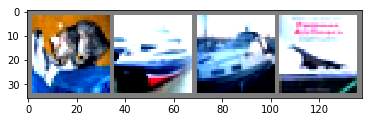

GroundTruth:    cat  ship  ship plane


In [48]:
# Test on images
image_batch, label_batch = next(iter(val_dataloader))
image_batch, label_batch = image_batch.to(device), label_batch.to(device)

# print images
imshow(torchvision.utils.make_grid(image_batch))
print('GroundTruth: ', ' '.join('%5s' % classes[label_batch[j]] for j in range(batch_size)))

In [49]:
outputs = model(image_batch)

In [50]:
predicted = torch.argmax(outputs, dim=1)

print("Predicted: {}".format(" ".join(classes[predicted[j]]for j in range(batch_size))))

Predicted: cat ship ship plane


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


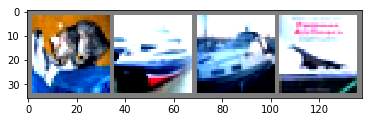

GroundTruth:    cat  ship  ship plane


In [25]:
# Validate whole model
image_batch, label_batch = next(iter(val_dataloader))
image_batch, label_batch = image_batch.to(device), label_batch.to(device)

# print images
imshow(torchvision.utils.make_grid(image_batch))
print('GroundTruth: ', ' '.join('%5s' % classes[label_batch[j]] for j in range(batch_size)))

In [51]:
model.eval()

correct = 0
total = 0
with torch.no_grad():
    for batch in tqdm(val_dataloader):
        image_batch, label_batch = batch
        image_batch, label_batch = image_batch.to(device), label_batch.to(device)
        
        outputs = model(image_batch)
        predicted = torch.argmax(outputs, dim=1)

        total += labels.size(0)
        correct += (predicted == label_batch).sum().item()

print("Accuracy of the network on the 10000 val images: {:.4}%".format(100 * correct / total))

Accuracy of the network on the 10000 val images: 65.71%
